In [91]:
pip install evaluate

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [92]:
import evaluate
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torchvision.transforms as T
import random
from PIL import Image
import os
from transformers import (ViTModel, 
                    ViTForMaskedImageModeling,AutoTokenizer, 
                    AutoModelForCausalLM,
                    DataCollatorWithPadding,
                    DataCollatorForLanguageModeling,
                    GenerationConfig)

%matplotlib inline


In [2]:
file = "/kaggle/input/mini-coco2014-dataset-for-image-captioning/captions.json"

captions = pd.read_json(file)
print(captions.head())
print(captions[captions.image_id == 299675])
print(captions.info())
print(captions.describe())

   image_id   id                                            caption
0    299675  328  A white square kitchen with tile floor that ne...
1    513461  572  A surfer, a woman, and a child walk on the beach.
2     18691  653  A few people sit on a dim transportation system. 
3    285579  668  A person, protected from the rain by their umb...
4    266366  674  The bathroom with a toilet has an interesting ...
    image_id    id                                            caption
0     299675   328  A white square kitchen with tile floor that ne...
6     299675   715       A white kitchen in a home with the light on.
13    299675  1558  A kitchen with a tile floor has cabinets with ...
24    299675  2689     A white kitchen without doors on the cabinets.
58    299675  6061  A white kitchen filled with pots, pans and dis...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93950 entries, 0 to 93949
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    -----------

Text(0.5, 0, 'Caption Length')

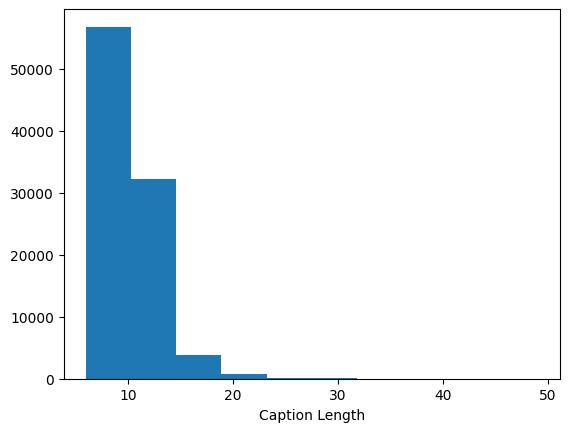

In [3]:
caption_lengths = captions["caption"].apply(lambda cap: len(cap.split()))
plt.hist(caption_lengths.values)
plt.xlabel("Caption Length")

In [4]:
image_size = 224
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

train_transform = T.Compose([
        T.Resize((image_size, image_size), antialias=True),
        T.RandomRotation(10),
        T.RandomResizedCrop(224),
        T.ToTensor(),
        T.Normalize(mean, std)])

val_transform = T.Compose([
        T.Resize((image_size, image_size), antialias=True),
        T.ToTensor(),
        T.Normalize(mean, std)])

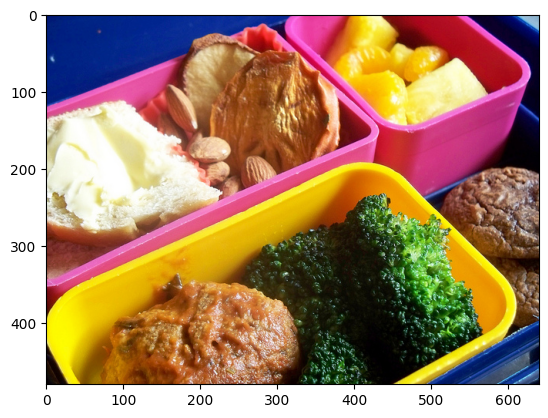

In [5]:
img_path = "/kaggle/input/mini-coco2014-dataset-for-image-captioning/Images/COCO_train2014_000000000009.jpg"

img = Image.open(img_path)

plt.imshow(img)



In [6]:
image_dir = "/kaggle/input/mini-coco2014-dataset-for-image-captioning/Images"
image_paths = []
i = 0
for img_path in os.listdir(image_dir):
    path = os.path.join(image_dir, img_path)
    img = Image.open(path)
    if img.mode != "RGB":
        continue
    image_paths.append(path)


random.Random(42).shuffle(image_paths)
# split images between training and val
val_size = 0.1
val_image_paths = image_paths[: int(val_size * len(image_paths))]
train_image_paths = image_paths[len(val_image_paths):]

In [7]:
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilgpt2")
# 82M parameters
decoder = AutoModelForCausalLM.from_pretrained("distilbert/distilgpt2")

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [8]:
tokenizer.special_tokens_map

{'bos_token': '<|endoftext|>',
 'eos_token': '<|endoftext|>',
 'unk_token': '<|endoftext|>'}

In [9]:
tokenizer.add_special_tokens(
    {
       "pad_token": "<PAD>",
        "sep_token": "<SEP>",
    }
)
decoder.resize_token_embeddings(len(tokenizer))

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Embedding(50259, 768)

In [10]:
decoder.config.hidden_size

768

In [11]:
decoder.parameters

<bound method Module.parameters of GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50259, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-5): 6 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50259, bias=False)
)>

In [12]:
# will train whole decoder

# for name, param in decoder.named_parameters():
#     # if "transformer.h.0" in name or \
#     #     "transformer.h.1" in name or \
#     #     "transformer.h.2" in name or \
#     #     "transformer.h.5" in name or \
#     if "transformer.h.3" in name or \
#         "transformer.h.4" in name or \
#         "transformer.h.5" in name or \
#         "transformer.ln" in name :
#         continue

#     param.requires_grad = False

# for param in decoder.lm_head.parameters():
#   param.requires_grad = True

for name , param in decoder.named_parameters(remove_duplicate=False):
    print(name, param.requires_grad)

transformer.wte.weight True
transformer.wpe.weight True
transformer.h.0.ln_1.weight True
transformer.h.0.ln_1.bias True
transformer.h.0.attn.c_attn.weight True
transformer.h.0.attn.c_attn.bias True
transformer.h.0.attn.c_proj.weight True
transformer.h.0.attn.c_proj.bias True
transformer.h.0.ln_2.weight True
transformer.h.0.ln_2.bias True
transformer.h.0.mlp.c_fc.weight True
transformer.h.0.mlp.c_fc.bias True
transformer.h.0.mlp.c_proj.weight True
transformer.h.0.mlp.c_proj.bias True
transformer.h.1.ln_1.weight True
transformer.h.1.ln_1.bias True
transformer.h.1.attn.c_attn.weight True
transformer.h.1.attn.c_attn.bias True
transformer.h.1.attn.c_proj.weight True
transformer.h.1.attn.c_proj.bias True
transformer.h.1.ln_2.weight True
transformer.h.1.ln_2.bias True
transformer.h.1.mlp.c_fc.weight True
transformer.h.1.mlp.c_fc.bias True
transformer.h.1.mlp.c_proj.weight True
transformer.h.1.mlp.c_proj.bias True
transformer.h.2.ln_1.weight True
transformer.h.2.ln_1.bias True
transformer.h.2.

In [13]:
captions[captions.image_id == 299675]["caption"].tolist()

['A white square kitchen with tile floor that needs repairs ',
 'A white kitchen in a home with the light on.',
 'A kitchen with a tile floor has cabinets with no doors, a dishwasher, a sink, and a refrigerator.',
 'A white kitchen without doors on the cabinets.',
 'A white kitchen filled with pots, pans and dishes.']

In [14]:
# implement a dict mapping image indices to all captions' tokens
captions_dict = {}
for img_idx in captions.image_id.unique():
    current_img_captions = captions[captions.image_id == img_idx]["caption"].tolist()
    tokenized_captions = tokenizer(current_img_captions, 
                                  truncation = True)

    num_captions = len(tokenized_captions["input_ids"])
    
    # add eos token for each caption
    for i in range(num_captions):
        tokenized_captions["input_ids"][i].append(tokenizer.eos_token_id)    
        tokenized_captions["attention_mask"][i].append(1)    
    
    captions_dict.update({img_idx: tokenized_captions})

In [15]:
tokenizer.decode(captions_dict[9]["input_ids"][0], skip_special_tokens=False)

'Closeup of bins of food that include broccoli and bread.<|endoftext|>'

In [16]:
# Vision Transformer base with 86M param
encoder = ViTModel.from_pretrained("facebook/deit-base-patch16-224")

config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at facebook/deit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
# will use the last hidden state and discard CLS token
encoder.parameters

<bound method Module.parameters of ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ViTLayer(
        (attention): ViTAttention(
          (attention): ViTSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUActivation()
        )
      

In [18]:
encoder

ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ViTLayer(
        (attention): ViTAttention(
          (attention): ViTSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUActivation()
        )
        (output): ViTOutput(
          (d

In [19]:
# freeze all encoder layers
for name, param in encoder.named_parameters():
    # if "encoder.layer.11" in name:
    #     continue

    param.requires_grad = False

# encoder.layernorm.weight.requires_grad = True
# encoder.layernorm.bias.requires_grad = True

In [20]:
for name, param in encoder.named_parameters():
    print(name, param.requires_grad)

embeddings.cls_token False
embeddings.position_embeddings False
embeddings.patch_embeddings.projection.weight False
embeddings.patch_embeddings.projection.bias False
encoder.layer.0.attention.attention.query.weight False
encoder.layer.0.attention.attention.query.bias False
encoder.layer.0.attention.attention.key.weight False
encoder.layer.0.attention.attention.key.bias False
encoder.layer.0.attention.attention.value.weight False
encoder.layer.0.attention.attention.value.bias False
encoder.layer.0.attention.output.dense.weight False
encoder.layer.0.attention.output.dense.bias False
encoder.layer.0.intermediate.dense.weight False
encoder.layer.0.intermediate.dense.bias False
encoder.layer.0.output.dense.weight False
encoder.layer.0.output.dense.bias False
encoder.layer.0.layernorm_before.weight False
encoder.layer.0.layernorm_before.bias False
encoder.layer.0.layernorm_after.weight False
encoder.layer.0.layernorm_after.bias False
encoder.layer.1.attention.attention.query.weight False
enc

In [21]:
class ImageCaptionDataset(Dataset):
    def __init__(self, image_paths, captions,transform=None):
        """
        image_paths: List of image paths 
        captions: a Dict mapping image indices to caption tokens
        transform: transform function from torchvision
        """
        self.image_paths = image_paths
        self.transform = transform
        self.captions = captions

    def __len__(self):
        return len(self.image_paths)

    def get_all_captions(self, idx):
        """
        return all available captions of an image of a certain index
        """ 
        # get image ID from image path
        # image extension must be of three char (jpg)
        img_index =  int(self.image_paths[idx].split("_")[-1][:-4])

        # a dict of batched tokenized captions
        return self.captions[img_index]["input_ids"]
        

    def __getitem__(self, idx):
        """
        return a transformed/normalized image with its randomly sampled
        caption from a list of captions.

        Returns:
            - img: Tensor 
            - caption: string(for now)
        """
        img = Image.open(self.image_paths[idx])
        
        if self.transform:
            img = self.transform(img)
            
        # get image ID from image path
        # image extension must be of three char (jpg)
        img_index =  int(self.image_paths[idx].split("_")[-1][:-4])

        # caption = random.choice(self.captions[self.captions.image_id == img_index]["caption"].values)
        
        # num of captions for this image
        num_captions = len(self.captions[img_index]["input_ids"])

        # a dict of batched tokenized captions
        current_img_captions = self.captions[img_index]
        
        # index of chosen caption from the group of captions for this image
        caption_indx = random.randint(0, num_captions - 1)
        
        # tokens of chosen caption
        caption_tokens =  {"input_ids": current_img_captions["input_ids"][caption_indx],
                           "attention_mask": current_img_captions["attention_mask"][caption_indx] }
        
        # return img, {"input_ids": current_img_captions["input_ids"][caption_indx],
        #             "attention_mask": current_img_captions["attention_mask"][caption_indx] }

        return {"pixel_values": img, "labels": caption_tokens }
        

Text(0.5, 0, 'A man standing next to a woman while wearing a skirt.<|endoftext|>')

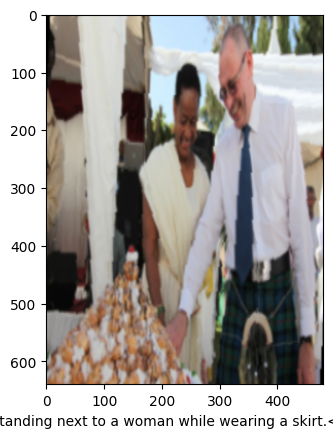

In [22]:
train_dataset = ImageCaptionDataset(train_image_paths, captions_dict, train_transform)
val_dataset = ImageCaptionDataset(val_image_paths, captions_dict, val_transform)

img, caption = train_dataset[3].values()

caption = tokenizer.decode(caption["input_ids"])

img = T.Normalize((-mean / std), (1.0 / std))(img)
img = T.Resize((640, 480), antialias=True)(img)
img = T.ToPILImage()(img)

plt.imshow(img)

plt.xlabel(caption)


Text(0.5, 0, 'A white cat sitting on a white sink with eyes opened.<|endoftext|>')

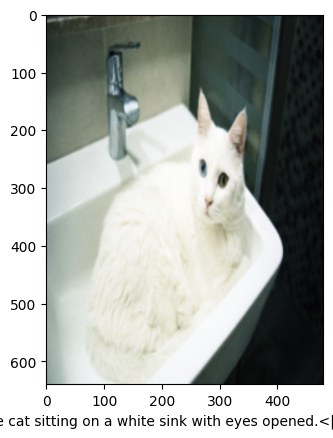

In [28]:
img, caption = val_dataset[3].values()

caption = tokenizer.decode(caption["input_ids"])
img = T.Normalize((-mean / std), (1.0 / std))(img)
img = T.Resize((640, 480), antialias=True)(img)
img = T.ToPILImage()(img)

plt.imshow(img)
plt.xlabel(caption)

In [29]:
img, _ = val_dataset[0].values()

encoder(img.unsqueeze(0))["last_hidden_state"].shape

torch.Size([1, 197, 768])

In [30]:
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer,
                                       return_tensors = "pt",
                                        mlm= False)
def collate_fn(batch):
    images = [item["pixel_values"] for item in batch]
    tokenized_captions = [item["labels"] for item in batch]

    pixel_values = torch.stack(images)
    tokenized_padded_captions = data_collator(tokenized_captions)
    return {
        "pixel_values": pixel_values,
        "input_ids": tokenized_padded_captions["input_ids"],
        "attention_mask": tokenized_padded_captions["attention_mask"],
        "labels": tokenized_padded_captions["labels"]
    }
    

In [31]:
train_dataloader = DataLoader(
    train_dataset, batch_size = 16, collate_fn = collate_fn)

val_dataloader = DataLoader(
    val_dataset, batch_size = 16, collate_fn = collate_fn)


In [33]:
for batch in train_dataloader:
    break


print(batch["pixel_values"].shape)
print(batch["input_ids"].shape)
print(batch["attention_mask"].shape)
print(batch["labels"].shape)
# print(batch["input_ids"][0])
# print(batch["attention_mask"][0])
# print(batch["labels"][0])

torch.Size([16, 3, 224, 224])
torch.Size([16, 16])
torch.int64
torch.Size([16, 16])


In [119]:
class ImageCaptioning(torch.nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.img_proj = nn.Sequential(
            nn.Linear(encoder.config.hidden_size, 2 * decoder.config.hidden_size),
            nn.GELU(),
            nn.Dropout(0.5),
            nn.Linear(2 * decoder.config.hidden_size, decoder.config.hidden_size)
        )

    def get_decoder_inp(self, pixel_values):
        """
        get decoder input which consists of 
        - encoder outputs concat with sep_token embeddings
        - their attention mask
        """
        image_features = self.encoder(pixel_values)["last_hidden_state"]
        img_embed = self.img_proj(image_features)
        # batch size
        B = img_embed.size(0)
        sep_token_id = tokenizer.sep_token_id
        sep_embed = self.decoder.transformer.wte(
            torch.tensor([sep_token_id], device=image_features.device))  # shape: [1, hidden_dim]
        # Repeat for batch
        sep_embed = sep_embed.unsqueeze(1).repeat(B, 1, 1)  # shape: [batch_size, 1, hidden_dim]

        # attention mask for images' tokens + sep_token
        prefix_len = img_embed.size(1) + 1  # +1 for sep token
        
        prefix_attention_mask = torch.ones((B, prefix_len),dtype=torch.int64, device=pixel_values.device)

        return torch.cat([img_embed, sep_embed], dim = 1), prefix_attention_mask
        

    def generate(self, pixel_values, **kwargs):
        """
        generate from tensor 'pixel_values'
        return caption as string
        """
        inputs_embeds, prefix_attention_mask = self.get_decoder_inp(pixel_values)
        
        return self.decoder.generate(inputs_embeds = inputs_embeds,
                             attention_mask = prefix_attention_mask,
                             **kwargs)
        
                
    def forward(self, pixel_values, input_ids = None, attention_mask = None, labels = None):
        
        image_features, prefix_attention_mask = self.get_decoder_inp(pixel_values)

        # mask labels
        if labels is not None:
            pad_labels = torch.full((B, prefix_len), -100, dtype=labels.dtype, device=labels.device)
            labels = torch.cat([pad_labels, labels], dim=1)
            
        # training
        text_embed = self.decoder.transformer.wte(input_ids)

        concat_embed = torch.cat([image_features, text_embed], dim=1)
        
        attention_mask = torch.cat([prefix_attention_mask, attention_mask], dim=1)

        return self.decoder(
            inputs_embeds = concat_embed,
            attention_mask = attention_mask,
            labels = labels)

            


In [120]:
model = ImageCaptioning(encoder, decoder)

In [121]:
model = nn.DataParallel(model)
device = "cuda" if torch.cuda.is_available() else "cpu"

In [122]:
# number of batches to report loss
epochs_to_run = 5
batch_report_every = 200
optim = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optim, mode='min', factor=0.5, patience=2)

In [123]:
checkpoint = torch.load("/kaggle/working/checkpoint_epoch_25.pth",  map_location=torch.device(device))

model.module.load_state_dict(checkpoint["model_state_dict"])
optim.load_state_dict(checkpoint["optimizer_state_dict"])

starting_epoch = checkpoint["epoch"] + 1
# starting_epoch = 20 + checkpoint["epoch"] + 1
# starting_epoch = 0

In [39]:
def evaluate_loss(model, val_dataloader):
  model.eval()
  val_loss = 0
  with torch.no_grad():
    for batch in val_dataloader:
      batch = {k : v.to(device) for k, v in batch.items()}

      outputs = model(**batch)

      val_loss += outputs.loss.mean().item()

  val_loss /= len(val_dataloader)
  return val_loss

In [68]:
for state in optim.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.to(device)

In [69]:
for param_group in optim.param_groups:
    # param_group["lr"] = 1e-6 #5e-7
    param_group["lr"] = 5e-4
    # print(param_group["lr"])
    

In [70]:
accumulate_steps = 8  # 8 x batch size 16 = 128

In [73]:
model = model.to(device)
Epochs = starting_epoch + epochs_to_run

for epoch in range(starting_epoch, Epochs):
  print(f"Epoch: {epoch}")
  model.train()
  avg_batch_loss = 0
  epoch_loss = 0
    
  for i, batch in enumerate(train_dataloader):
    
    batch = {k : v.to(device) for k, v in batch.items()}

    outputs = model(**batch)

    # loss.mean() because of distributed training
    # loss = outputs.loss.mean()
    loss = outputs.loss.mean() / accumulate_steps
      
    # optim.zero_grad()

    loss.backward()

    if i % accumulate_steps == 0:
        optim.step()
        optim.zero_grad()
    
    # optim.step()

    avg_batch_loss += loss.item() * accumulate_steps
    epoch_loss += loss.item() * accumulate_steps
    # avg_batch_loss += loss.item() 
    # epoch_loss += loss.item()

    # print avg batch loss
    if not (i + 1) % batch_report_every:
      avg_batch_loss /= batch_report_every
      print(f"-----Batches {i + 1 - batch_report_every} -- {i+1} | Avg Batch Training Loss: {avg_batch_loss}", flush=True)
      avg_batch_loss = 0

    # print val loss after 750 batches and update sheduler
    if not (i + 1) % 500:
        val_loss = evaluate_loss(model, val_dataloader)
        print(f"-----Val loss: {val_loss}\n")
        scheduler.step(val_loss)
        
  # scheduler.step(val_loss)        
  epoch_loss /= len(train_dataloader)
  print(f"-----Training Loss: {epoch_loss}", flush=True)
    
  # save after each epoch
  torch.save({
        'epoch': epoch,
        'model_state_dict': model.module.state_dict(),
        'optimizer_state_dict': optim.state_dict(),
        'loss': loss.item(),
    }, f'checkpoint_epoch_{epoch}.pth')
    
  val_loss = evaluate_loss(model, val_dataloader)
  
  print(f"-----Validation Loss: {val_loss}", flush=True)
  print("=============================================", flush=True)

Epoch: 21
-----Batches 0 -- 200 | Avg Batch Training Loss: 1.676304778456688
-----Batches 200 -- 400 | Avg Batch Training Loss: 1.7113068354129792
-----Val loss: 2.3637064220541615

-----Batches 400 -- 600 | Avg Batch Training Loss: 1.6571460306644439
-----Batches 600 -- 800 | Avg Batch Training Loss: 1.5081318897008895
-----Batches 800 -- 1000 | Avg Batch Training Loss: 1.4873081612586976
-----Val loss: 2.565280833486783

-----Training Loss: 1.602146888932874
-----Validation Loss: 2.5412898740525973
Epoch: 22
-----Batches 0 -- 200 | Avg Batch Training Loss: 1.713173310160637
-----Batches 200 -- 400 | Avg Batch Training Loss: 1.7037149751186371
-----Val loss: 2.3852631368879544

-----Batches 400 -- 600 | Avg Batch Training Loss: 1.6365943229198456
-----Batches 600 -- 800 | Avg Batch Training Loss: 1.4921168488264085
-----Batches 800 -- 1000 | Avg Batch Training Loss: 1.4632401716709138
-----Val loss: 2.5792916356506996

-----Training Loss: 1.5923819900463836
-----Validation Loss: 2.572

In [124]:
bleu = evaluate.load("bleu")
all_references = []
all_generated = []
model.to(device)
for i in range(len(val_dataset)):
    if i % 200 == 0:
        print(f"Remains: {len(val_dataset) - i}")
        
    image_captions = val_dataset.get_all_captions(i)
    img, _ = val_dataset[i].values()
    img = img.to(device)
    image_captions = tokenizer.batch_decode(image_captions, skip_special_tokens=True)
    pred_caption = model.module.generate(img.unsqueeze(0),
                            max_new_tokens=50,
                            do_sample = True,
                            temperature= 0.5,
                            top_p = 0.9, 
                            num_beams = 5,
                           pad_token_id=tokenizer.pad_token_id)
    
    pred_caption = tokenizer.decode(pred_caption[0], skip_special_tokens = True)
    
    all_references.append(image_captions)
    all_generated.append(pred_caption)

Remains: 1873
Remains: 1673
Remains: 1473
Remains: 1273
Remains: 1073
Remains: 873
Remains: 673
Remains: 473
Remains: 273
Remains: 73


In [129]:
for i in range(5):
    print(all_references[i])
    print(all_generated[i])
    print()

['A woman on a deck having just finished eating', 'A cat laying on a banister next to a woman sitting at a table.', 'A cat on top of a rail next to a woman sitting at a table.', 'A lady has just about finished her plate with a knife. ', 'A woman with a cat and an empty plate.']
A man sitting at a table with a plate of food.

['A boy is doing a trick on a skateboard', 'A man jumping up in the air on a skateboard.', 'A man jumps on the side walk during a skateboard trick.', 'People performing a variety of skateboard tricks outside a building.', 'a couple of people skateboarding on a  ramp near a building']
A man riding a skateboard up the side of a ramp.

['An older woman walks in the rain with her umbrella.', 'A woman carrying an umbrella and walking in the rain.', 'A woman in a raincoat carrying an umbrella in the rain.', 'an old lady that looks soaking wet yet under an umbrella', 'a woman under an umbrella walking down the sidewalk on a rainy day']
A woman walking down a street holdin

In [131]:
score = bleu.compute(predictions= all_generated, references=all_references, max_order=1)
print(score)

{'bleu': 0.6640222495782611, 'precisions': [0.6640222495782611], 'brevity_penalty': 1.0, 'length_ratio': 1.285412881673797, 'translation_length': 21933, 'reference_length': 17063}


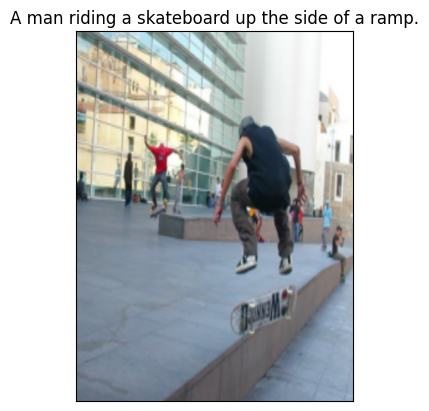

In [177]:
img, _ = val_dataset[1].values()

img = T.Normalize((-mean / std), (1.0 / std))(img)
img = T.Resize((640, 480), antialias=True)(img)
img = T.ToPILImage()(img)

plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title(all_generated[1])

plt.savefig("my_plot.png", bbox_inches='tight', dpi=150)

print()

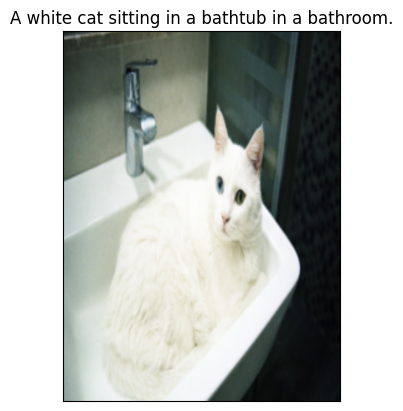

In [179]:
img, _ = val_dataset[3].values()

img = T.Normalize((-mean / std), (1.0 / std))(img)
img = T.Resize((640, 480), antialias=True)(img)
img = T.ToPILImage()(img)

plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title(all_generated[3])
print()

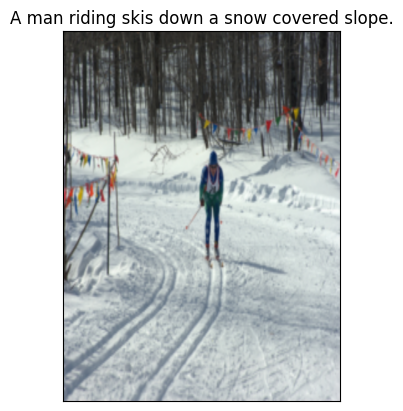

In [180]:
img, _ = val_dataset[4].values()

img = T.Normalize((-mean / std), (1.0 / std))(img)
img = T.Resize((640, 480), antialias=True)(img)
img = T.ToPILImage()(img)

plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title(all_generated[4])
print()

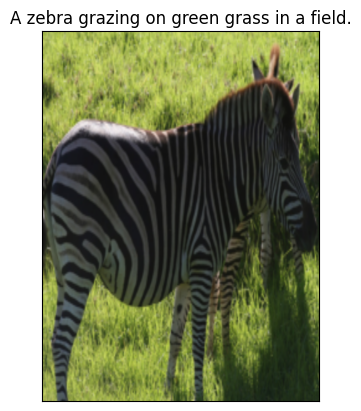

In [181]:
img, _ = val_dataset[5].values()

img = T.Normalize((-mean / std), (1.0 / std))(img)
img = T.Resize((640, 480), antialias=True)(img)
img = T.ToPILImage()(img)

plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title(all_generated[5])
print()